<a href="https://colab.research.google.com/github/thunchanok-tangpong/fraud_detection/blob/main/Datacamp_fruad_detection_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction and preparing your data

### Checking the fraud to non-fraud ratio

In [ ]:
# Import pandas and read csv
import pandas as pd
df = pd.read_csv("creditcard_data.csv")

# Explore the features available in your dataframe
print(df.info())

# Count the occurrences of fraud and no fraud and print them
occ = df['Class'].value_counts()
print(occ)

# Print the ratio of fraud cases
print(occ / len(df))

### Plotting your data

In [ ]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X, y):
	plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
	plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
	plt.legend()
	return plt.show()

# Create X and y from the prep_data function
X, y = prep_data(df)

# Plot our data by running our plot data function on X and y
plot_data(X, y)

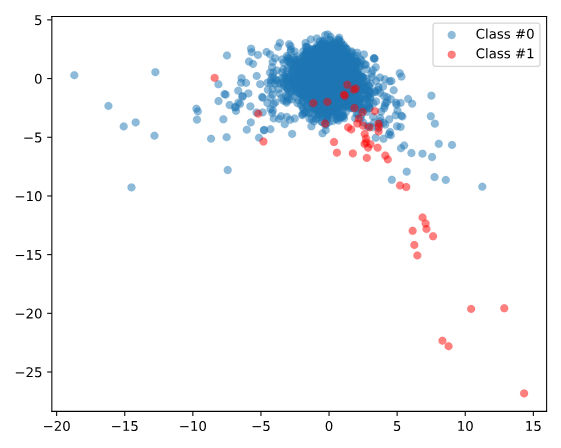

## **Applying SMOTE**

**Applying SMOTE**

re-balance data using the Synthetic Minority Over-sampling Technique (SMOTE). Unlike ROS, SMOTE does not create exact copies of observations, but creates new, synthetic, samples that are quite similar to the existing observations in the minority class. SMOTE is therefore slightly more sophisticated than just copying observations.

In [ ]:
from imblearn.over_sampling import SMOTE

# Run the prep_data function
X, y = prep_data(df)

# Define the resampling method
method = SMOTE()

# Create the resampled feature set
X_resampled, y_resampled = method.fit_resample(X, y)

# Plot the resampled data
plot_data(X_resampled, y_resampled)

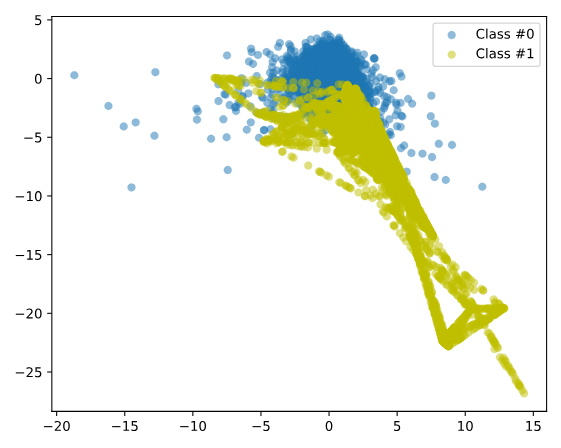

## **Compare SMOTE to original data**

In [ ]:
# Print the value_counts on the original labels y
print(pd.value_counts(pd.Series(y)))

# Print the value_counts
print(pd.value_counts(pd.Series(y_resampled)))

# Run compare_plot
compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

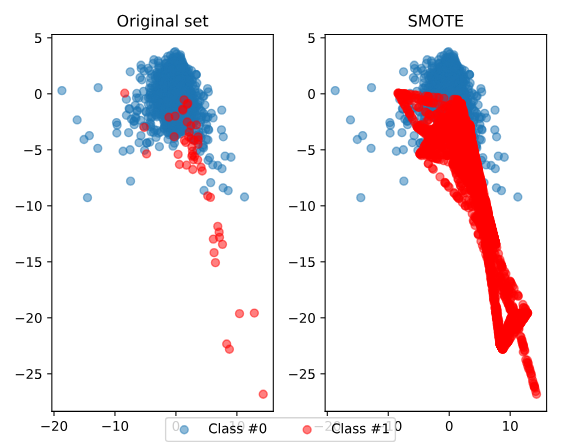

It should by now be clear that  SMOTE has balanced data completely, and that the minority class is now equal in size to the majority class. Visualizing the data shows the effect on data very clearly.

## Exploring the traditional way to catch fraud

**Exploring the traditional way to catch fraud**

finding fraud cases in credit card dataset the "old way". First you'll define threshold values using common statistics, to split fraud and non-fraud. Then, use those thresholds on features to detect fraud. This is common practice within fraud analytics teams

In [ ]:
# Get the mean for each group
df.groupby('Class').mean()

# Implement a rule for stating which cases are flagged as fraud
df['flag_as_fraud'] = np.where(np.logical_and(df['V1']<-3, df['V3']<-5), 1, 0)

# Create a crosstab of flagged fraud cases versus the actual fraud cases
print(pd.crosstab(df.Class, df.flag_as_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

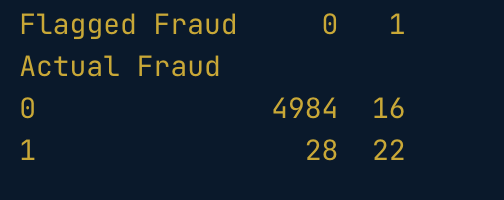

Not bad, with this rule, we detect 22 out of 50 fraud cases, but can't detect the other 28, and get 16 false positives

## **Using Logistic regression to catch fraud**

In [ ]:
# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit a logistic regression model to our data
model = LogisticRegression()
model.fit(X_train, y_train)

# Obtain model predictions
predicted = model.predict(X_test)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

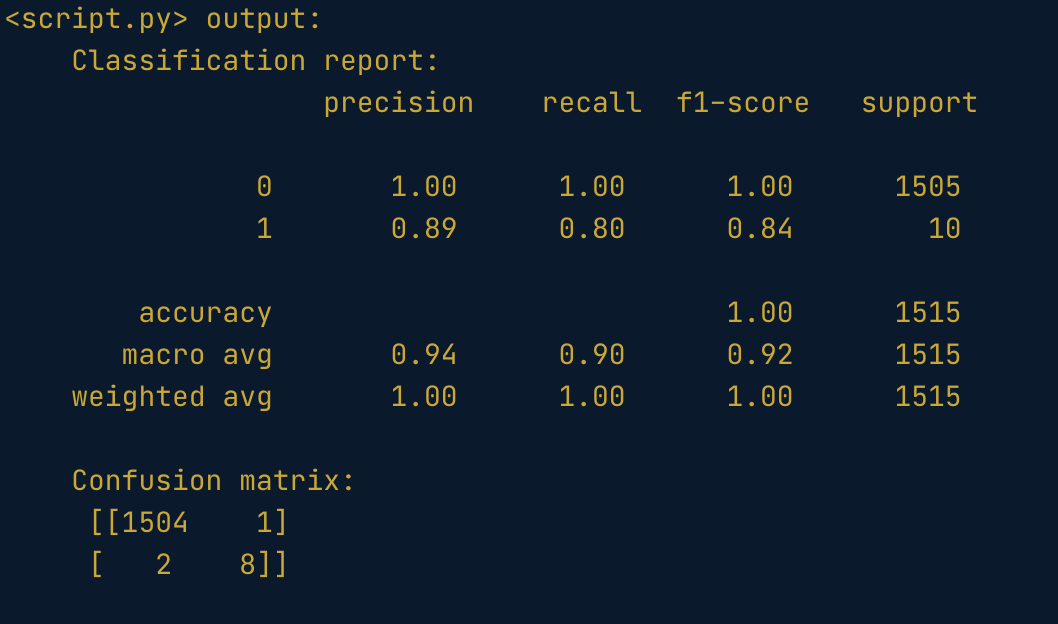

## Using Pipeline

**Logistic regression combined with SMOTE**

In [ ]:
# This is the pipeline module we need for this from imblearn
from imblearn.pipeline import Pipeline

# Define which resampling method and which ML model to use in the pipeline
resampling = SMOTE()
model = LogisticRegression()

# Define the pipeline, tell it to combine SMOTE with the Logistic Regression model
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data
pipeline.fit(X_train, y_train)
predicted = pipeline.predict(X_test)

# Obtain the results from the classification report and confusion matrix
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

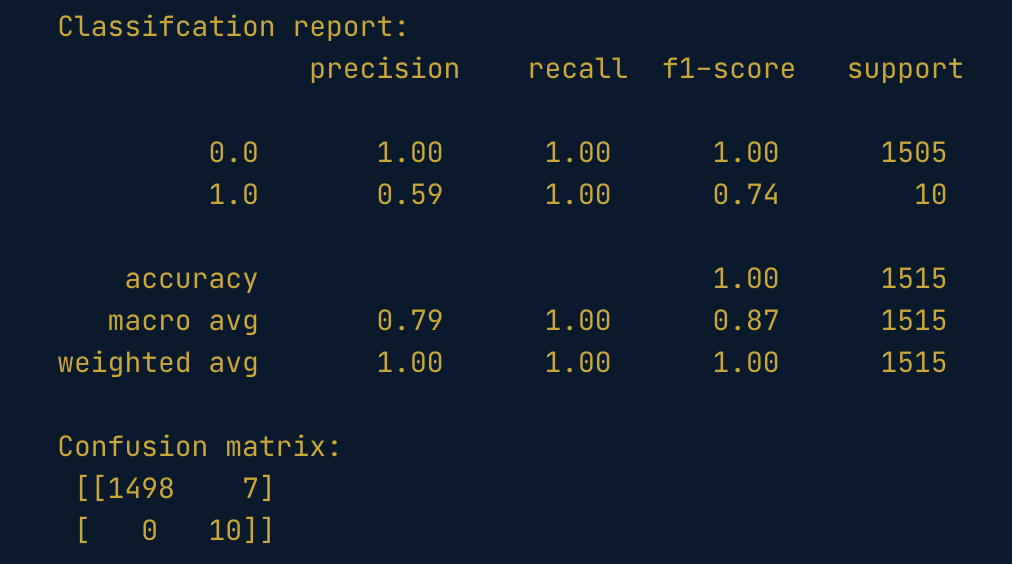

As you can see, the SMOTE slightly improves recall results. Remember, not in all cases does resampling necessarily lead to better results. When the fraud cases are very spread and scattered over the data, using SMOTE can introduce a bit of bias. Nearest neighbors aren't necessarily also fraud cases, so the synthetic samples might 'confuse' the model slightly.

# Fraud detection using labeled data

## Natural hit rate

**Natural hit rate**

Naturally, the fraud data is heavily imbalanced. First you need to explore how prevalent fraud is in the dataset, to understand what the "natural accuracy" is, if we were to predict everything as non-fraud. It's is important to understand which level of "accuracy" you need to "beat" in order to get a better prediction than by doing nothing.

In [ ]:
# Count the total number of observations from the length of y
total_obs = len(y)

# Count the total number of non-fraudulent observations
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)

# Calculate the percentage of non fraud observations in the dataset
percentage = (float(count_non_fraud)/float(total_obs)) * 100

# Print the percentage: this is our "natural accuracy" by doing nothing
print(percentage)

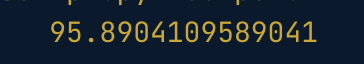

This tells us that by doing nothing, we would be correct in 95.9% of the cases. So now you understand, that if we get an accuracy of less than this number, our model does not actually add any value in predicting how many cases are correct.

## **Random Forest Classifier**

In [ ]:
# Import the random forest model from sklearn
from sklearn.ensemble import RandomForestClassifier

# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define the model as the random forest
model = RandomForestClassifier(random_state=5)
model.fit(X_train, y_train)

# Obtain predictions from the test data
predicted = model.predict(X_test)
# Print the accuracy performance metric
print(accuracy_score(y_test, predicted))

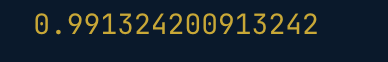

## Performance Evaluation

**Performance metrics for the RF model**

accuracy can be misleading in the case of fraud detection. With highly imbalanced fraud data, the AUROC curve is a more reliable performance metric, used to compare different classifiers. Moreover, the classification report tells you about the precision and recall of your model, whilst the confusion matrix actually shows how many fraud cases you can predict correctly.



In [ ]:
# Import the packages to get the different performance metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Obtain the predictions from our random forest model
predicted = model.predict(X_test)

# Predict probabilities
probs = model.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

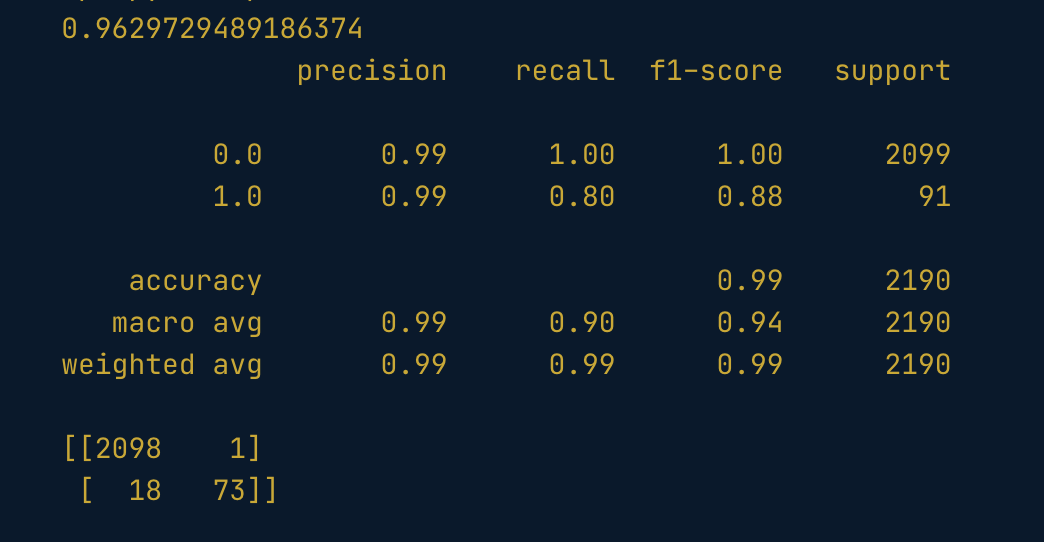

The model predicts 74 cases of fraud, out of which 73 are actual fraud. You have only 1 false positives. This is really good, and as a result you have a very high precision score. You do however, don't catch 18 cases of actual fraud. Recall is therefore not as good as precision

**Plotting the Precision Recall Curve**

You can also plot a Precision-Recall curve, to investigate the trade-off between the two in your model. In this curve Precision and Recall are inversely related; as Precision increases, Recall falls and vice-versa. A balance between these two needs to be achieved in your model, otherwise you might end up with many false positives, or not enough actual fraud cases caught. To achieve this and to compare performance, the precision-recall curves come in handy.

In [ ]:
# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)

# Obtain precision and recall
precision, recall, _ = precision_recall_curve(y_test, predicted)

# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

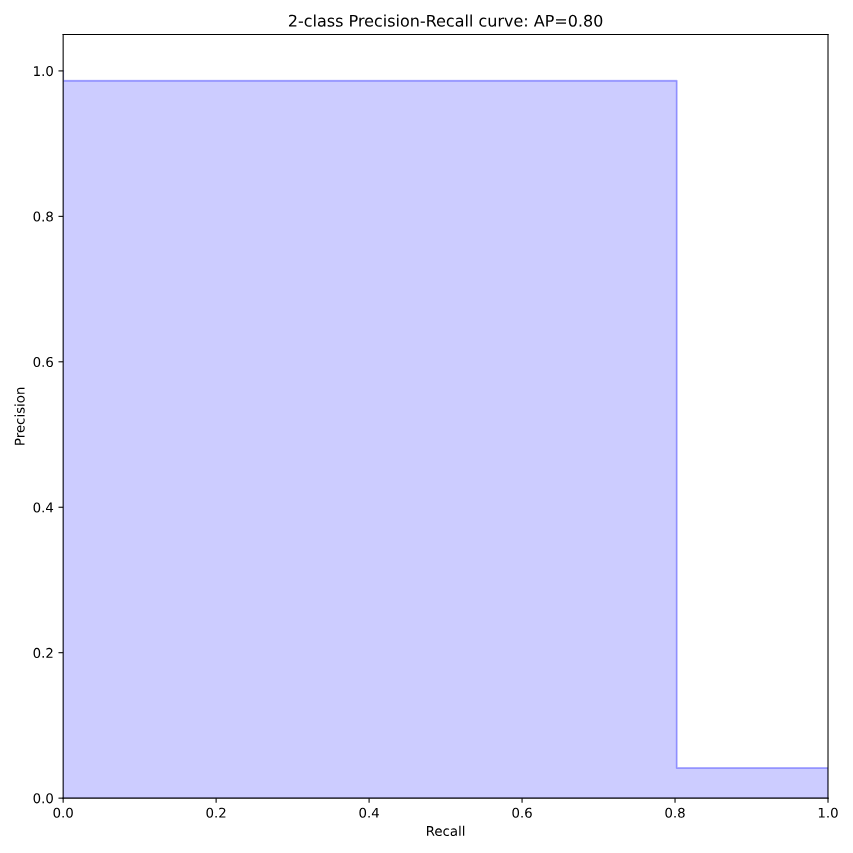

## Model adjustments

**Model adjustments**

A simple way to adjust the random forest model to deal with highly imbalanced fraud data, is to use the **class_weights** option

In [ ]:
# Define the model with balanced subsample
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=5)

# Fit your training model to your training set
model.fit(X_train, y_train)

# Obtain the predicted values and probabilities from the model
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# Print the roc_auc_score, the classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

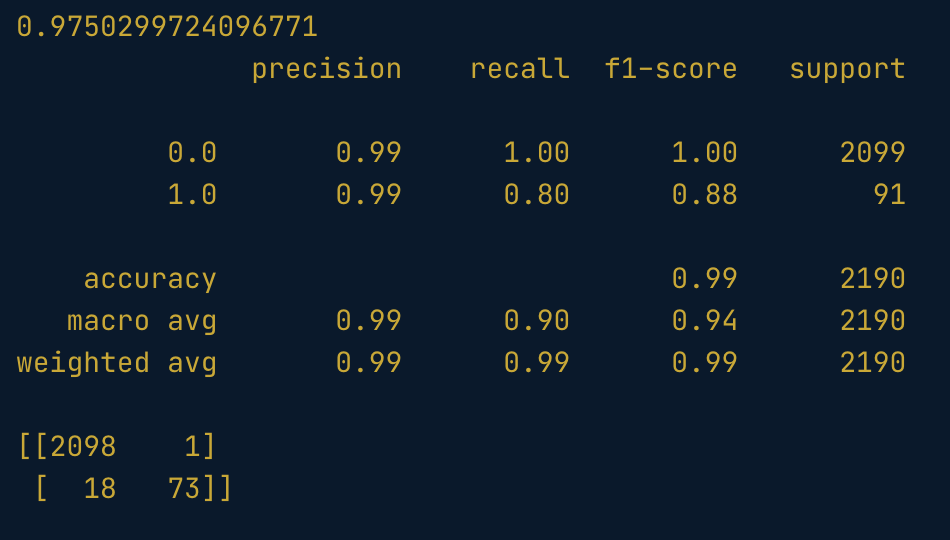

**Adjusting your Random Forest to fraud detection**

In [ ]:
# Change the model options
model = RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:12}, criterion='entropy',

			# Change depth of model
            max_depth=10,

			# Change the number of samples in leaf nodes
            min_samples_leaf=10,

			# Change the number of trees to use
            n_estimators=20, n_jobs=-1, random_state=5)

# Run the function get_model_results
get_model_results(X_train, y_train, X_test, y_test, model)

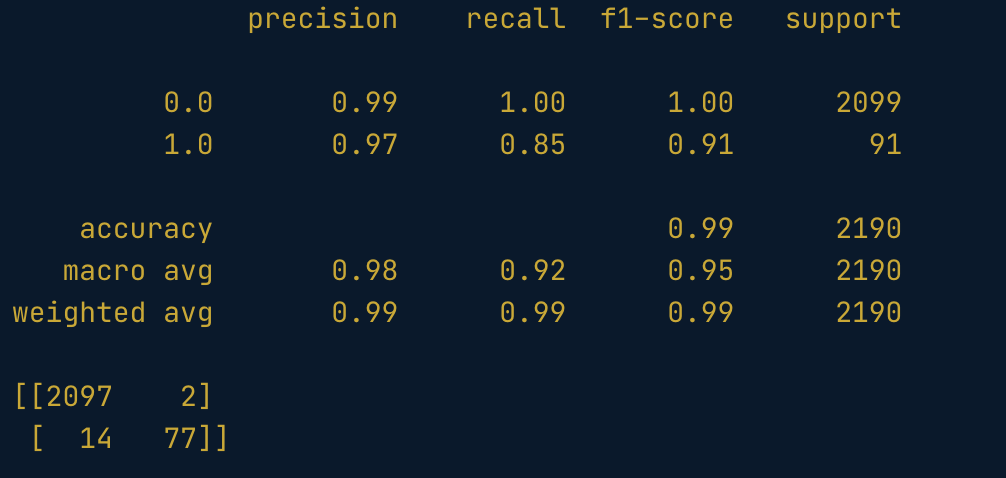

you can obtain better predictions. You have effectively reduced the number of false negatives, i.e. you are catching more cases of fraud, whilst keeping the number of false positives low. In this exercise you've manually changed the options of the model. There is a smarter way of doing it, by using GridSearchCV, which you'll see in the next exercise!

**GridSearchCV to find optimal parameters**

With GridSearchCV you can define which performance metric to score the options on. Since for fraud detection we are mostly interested in catching as many fraud cases as possible, you can optimize your model settings to get the best possible Recall score. If you also cared about reducing the number of false positives, you could optimize on F1-score, this gives you that nice Precision-Recall trade-off.

In [ ]:
# Define the parameter sets to test
param_grid = {'n_estimators': [1, 30], 'max_features': ['auto', 'log2'],  'max_depth': [4, 8], 'criterion': ['gini', 'entropy']
}

# Define the model to use
model = RandomForestClassifier(random_state=5)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

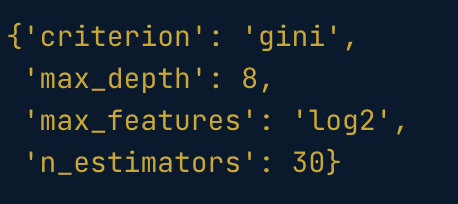

In [ ]:
# Input the optimal parameters in the model
model = RandomForestClassifier(class_weight={0:1,1:12}, criterion='gini',
            n_estimators=30, max_features='log2',  min_samples_leaf=10, max_depth=8, n_jobs=-1, random_state=5)

# Get results from your model
get_model_results(X_train, y_train, X_test, y_test, model)

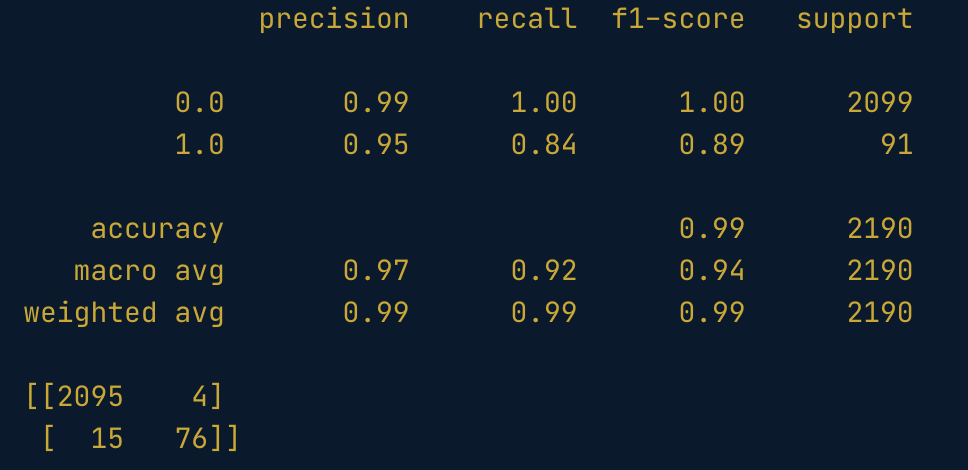

## Ensamble method

***Voting Classifier***

you'll combine three algorithms into one model with the VotingClassifier. This allows us to benefit from the different aspects from all models, and hopefully improve overall performance and detect more fraud. The first model, the Logistic Regression, has a slightly higher recall score than our optimal Random Forest model, but gives a lot more false positives. You'll also add a Decision Tree with balanced weights to it.

In [ ]:
# Import the package
from sklearn.ensemble import VotingClassifier

# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(class_weight={0:1, 1:15}, random_state=5)
clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, criterion='gini', max_depth=8, max_features='log2',
            min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=5)
clf3 = DecisionTreeClassifier(random_state=5, class_weight="balanced")

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')

# Get the results
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

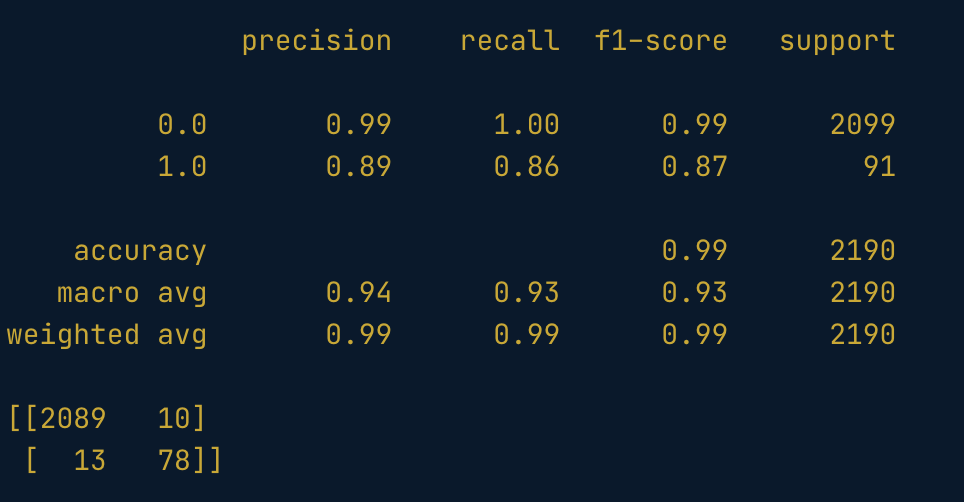

**Adjust weights within the Voting Classifier**

In [ ]:
# Define the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[1, 4, 1], flatten_transform=True)

# Get results
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

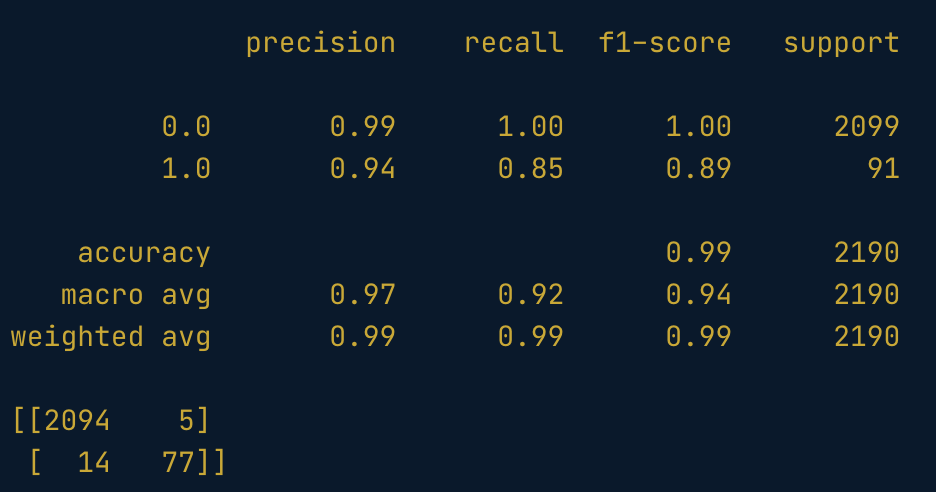

# Fraud detection using unlabeled data

### distinguish normal from abnormal

In [ ]:
# Get the dataframe shape
df.shape

# Display the first 5 rows
df.head(5)

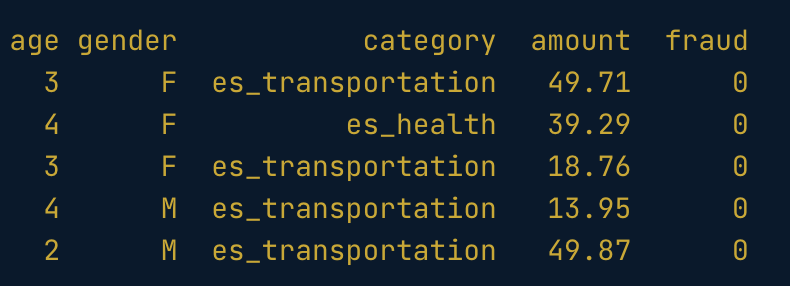

In [ ]:
# Groupby categories and take the mean
print(df.groupby('category').mean())

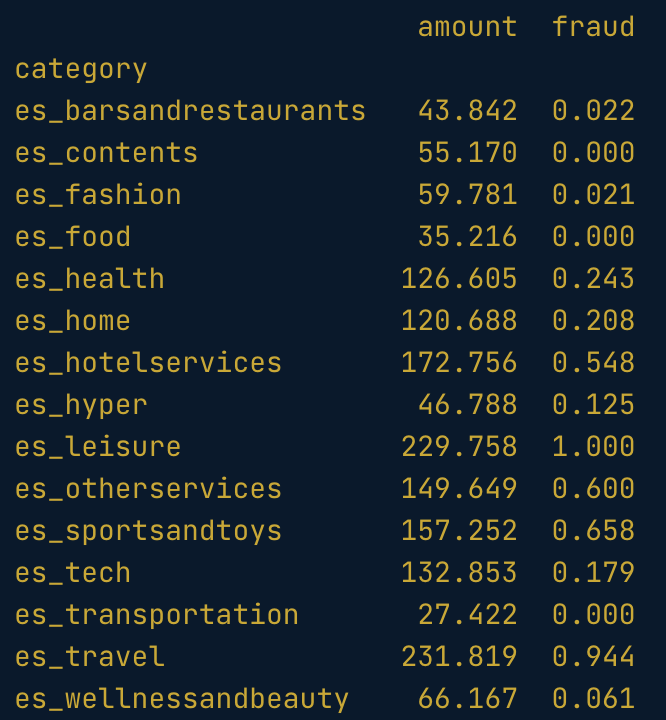

as you can see, the majority of fruad is observed in travel, leisure, and sport related transaction

### **Using statistics to define normal behavior**


In [ ]:
# Create two dataframes with fraud and non-fraud data
df_fraud = df.loc[df.fraud == 1]
df_non_fraud = df.loc[df.fraud == 0]

# Plot histograms of the amounts in fraud and non-fraud data
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.legend()
plt.show()

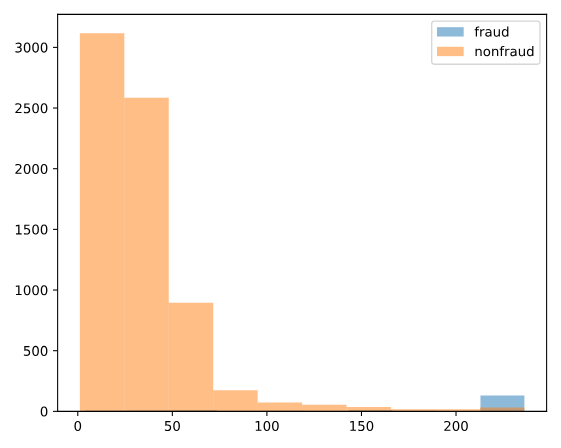

As the number fraud observations is much smaller, it is difficult to see the full distribution. Nonetheless, you can see that the fraudulent transactions tend to be on the larger side relative to normal obervations. This is good news, as it helps us later in detecting fraud from non-fraud.

## Clustering methods to detect fraud

**Scaling the data**

For ML algorithms using distance based metrics, it is crucial to always scale your data, as features using different scales will distort your results. K-means uses the Euclidian distance to assess distance to cluster centroids, therefore you first need to scale your data before continuing to implement the algorithm. Let's do that first.

In [ ]:
# Import the scaler
from sklearn.preprocessing import MinMaxScaler

# Take the float values of df for X
X = df.values.astype(np.float)

# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)



**MiniBatch K-means**



In [ ]:
# Import MiniBatchKmeans
from sklearn.cluster import MiniBatchKMeans

# Define the model
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Fit the model to the scaled data
kmeans.fit(X_scaled)

**Elbow method**

In the previous exercise you've implemented MiniBatch K-means with 8 clusters, without actually checking what the right amount of clusters should be. For our first fraud detection approach, it is important to get the number of clusters right, especially when you want to use the outliers of those clusters as fraud predictions. To decide which amount of clusters you're going to use, let's apply the Elbow method and see what the optimal number of clusters should be based on this method.

In [ ]:
# Define the range of clusters to try
clustno = range(1, 5)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i, random_state=0) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

# Plot the models and their respective score
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

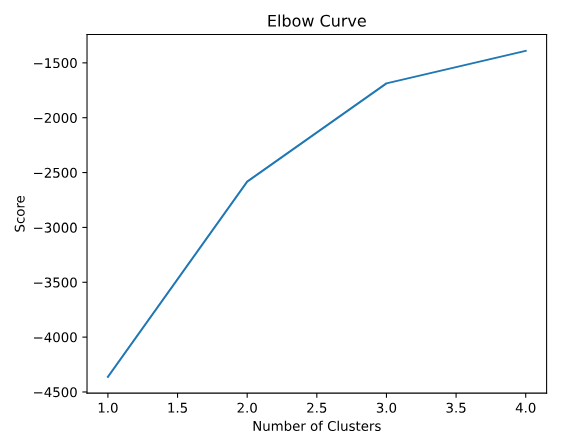

Now you can see that the optimal number of clusters should probably be at around 3 clusters, as that is where the elbow is in the curve.

## Assigning fraud versus non-fraud

**Detecting outliers**

The fraudulent transactions are typically flagged as the observations that are furthest aways from the cluster centroid. You'll learn how to do this and how to determine the cut-off in this exercise.

In [ ]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

# Define K-means model
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

# Obtain the ROC score
print(roc_auc_score(y_test, km_y_pred))

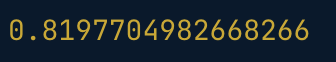

In [ ]:
# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

# Plot the confusion matrix in a figure to visualize results
plot_confusion_matrix(km_cm)

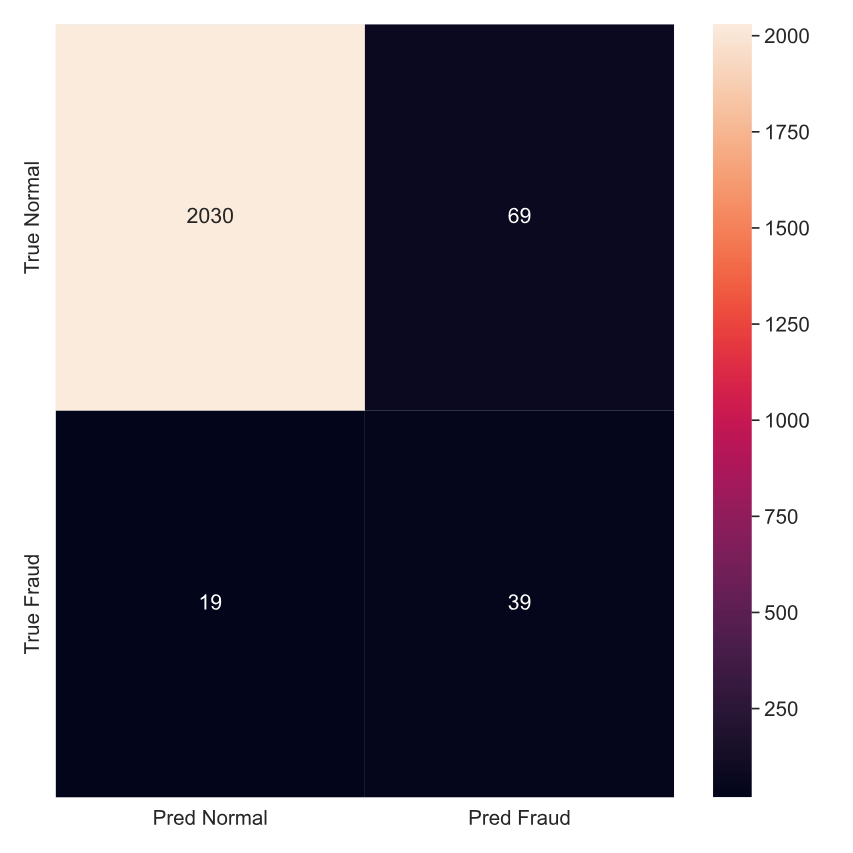

By lowering the threshold for cases flagged as fraud, you flag more cases overall but thereby also get more false positives

## Other clustering fraud detection methods

**DBSCAN**

you're going to explore using a density based clustering method (DBSCAN) to detect fraud. The advantage of DBSCAN is that you do not need to define the number of clusters beforehand. Also, DBSCAN can handle weirdly shaped data (i.e. non-convex) much better than K-means can. This time, you are not going to take the outliers of the clusters and use that for fraud, but take the smallest clusters in the data and label those as fraud.

In [ ]:
# Import DBSCAN
from sklearn.cluster import DBSCAN

# Initialize and fit the DBSCAN model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_scaled)

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)

# Print performance metrics for DBSCAN
print('Estimated number of clusters: %d' % n_clusters)
print("Homogeneity: %0.3f" % homogeneity_score(labels, pred_labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_scaled, pred_labels))

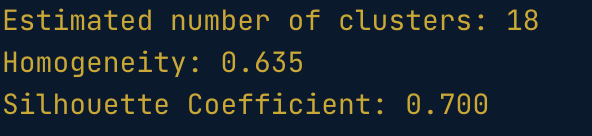

The number of clusters is much higher than with K-means. For fraud detection this is for now OK, as we are only interested in the smallest clusters, since those are considered as abnormal. Now let's have a look at those clusters and decide which one to flag as fraud.

**Assessing smallest clusters**

In this exercise you're going to have a look at the clusters that came out of DBSCAN, and flag certain clusters as fraud:

you first need to figure out how big the clusters are, and filter out the smallest
then, you're going to take the smallest ones and flag those as fraud
last, you'll check with the original labels whether this does actually do a good job in detecting fraud.


In [ ]:
# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels >= 0])

# Print the result
print(counts)

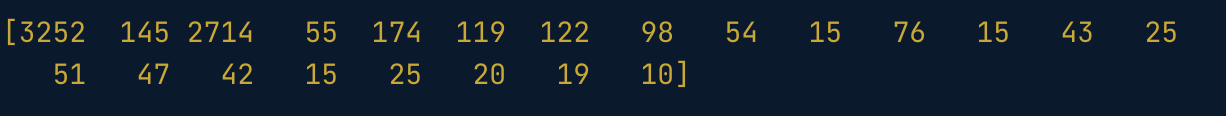

In [ ]:
# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]

# Print the results
print("The smallest clusters are clusters:")
print(smallest_clusters)

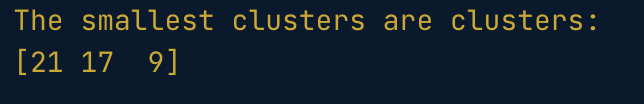

In [ ]:
# Print the counts of the smallest clusters only
print("Their counts are:")
print(counts[smallest_clusters])

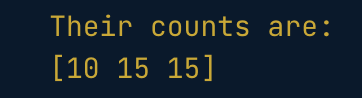

So now we know which smallest clusters you could flag as fraud. If you were to take more of the smallest clusters, you cast your net wider and catch more fraud, but most likely also more false positives. It is up to the fraud analyst to find the right amount of cases to flag and to investigate.

In [ ]:
# Create a dataframe of the predicted cluster numbers and fraud labels
df = pd.DataFrame({'clusternr':pred_labels,'fraud':labels})

# Create a condition flagging fraud for the smallest clusters
df['predicted_fraud'] = np.where((df['clusternr']==21)|((df['clusternr']==17))|((df['clusternr']==9)),1 , 0)

# Run a crosstab on the results
print(pd.crosstab(df['fraud'], df['predicted_fraud'], rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

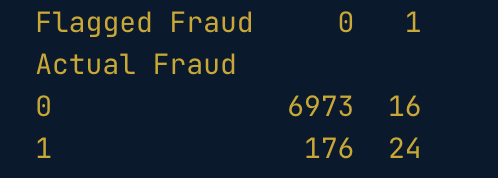

The good thing is: our of all flagged cases, roughly 2/3 are actually fraud! Since you only take the three smallest clusters, by definition you flag less cases of fraud, so you catch less but also have less false positives. However, you are missing quite a lot of fraud cases. Increasing the amount of smallest clusters you flag could improve that, at the cost of more false positives of course. In the next chapter you'll learn how to further improve fraud detection models by including text analysis.

# Fraud detection using text

## Fraud detection using text

### **Word search with dataframes**

In [ ]:
# Create a list of terms to search for
searchfor = ['enron stock', 'sell stock', 'stock bonus', 'sell enron stock']

# Filter cleaned emails on searchfor list and select from df
filtered_emails = df.loc[df['clean_content'].str.contains('|'.join(searchfor), na=False)]

# Create flag variable where the emails match the searchfor terms
df['flag'] = np.where((df['clean_content'].str.contains('|'.join(searchfor)) == True), 1, 0)

# Count the values of the flag variable
count = df['flag'].value_counts()


### Text mining to detect fraud

**Cleaning text data**

In [ ]:
# Import the lemmatizer from nltk
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()

# Define word cleaning function
def clean(text, stop):
    text = text.rstrip()
	# Remove stopwords
    stop_free = " ".join([word for word in text.lower().split() if ((word not in stop) and (not word.isdigit()))])
	# Remove punctuations
    punc_free = ''.join(word for word in stop_free if word not in exclude)
	# Lemmatize all words
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [ ]:
# Clean the emails in df and print results
text_clean=[]
for text in df['clean_content']:
    text_clean.append(clean(text, stop).split())

## **Topic modeling on fraud**

In [ ]:
# Import the packages
import gensim
from gensim import corpora

# Define the dictionary
dictionary = corpora.Dictionary(text_clean)

# Define the corpus
corpus = [dictionary.doc2bow(text) for text in text_clean]

# Print corpus and dictionary
print(corpus)
print(dictionary)

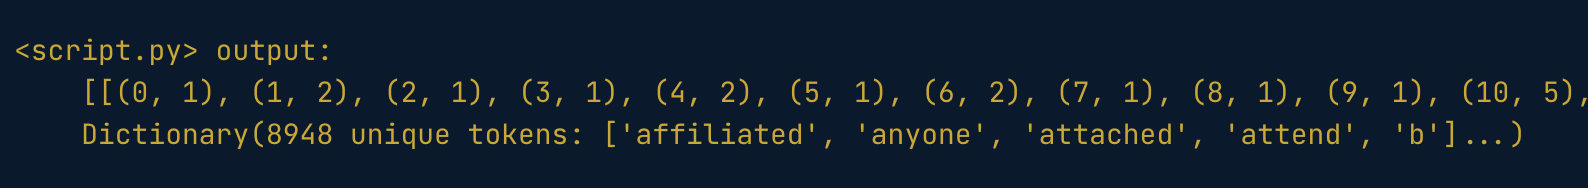

In [ ]:
# Define the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=5)

# Save the topics and top 5 words
topics = ldamodel.print_topics(num_words=5)

# Print the results
for topic in topics:
    print(topic)

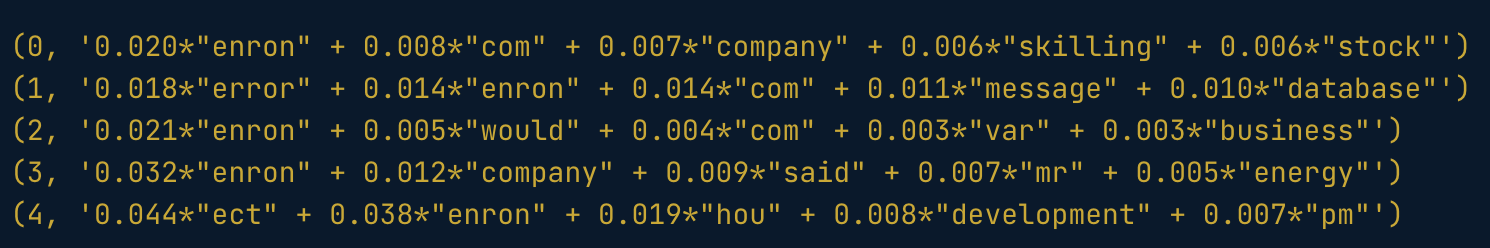

However, the print of words doesn't really give you enough information to find a topic that might lead you to signs of fraud. You'll therefore need to closely inspect the model results in order to be able to detect anything that can be related to fraud in your data.

## **Flagging fraud based on topics**

**Interpreting the topic model**

Below are visualisation results from the pyLDAvis library available. Topic 3 and 3 from the LDA model on the Enron email data relate to fraud

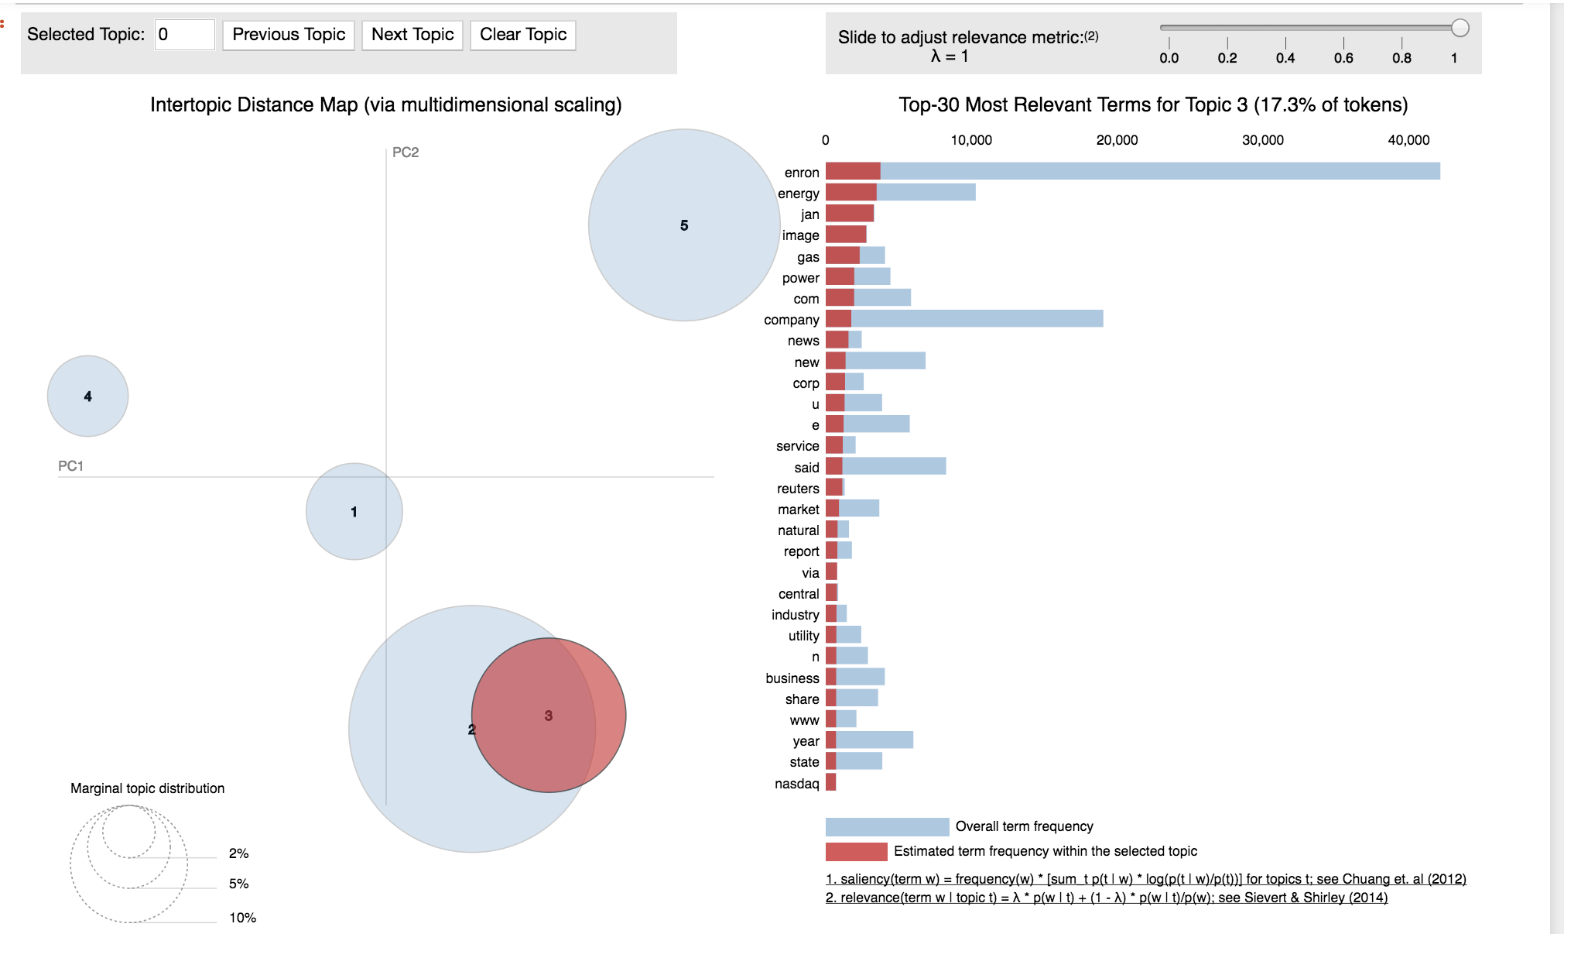

**Finding fraudsters based on topic**

In this exercise you're going to link the results from the topic model back to your original data. You now learned that you want to flag everything related to topic 3. As you will see, this is actually not that straightforward. You'll be given the function `get_topic_details()` which takes the arguments ldamodel and corpus. It retrieves the details of the topics for each line of text. With that function, you can append the results back to your original data.

In [ ]:
# Run get_topic_details function and check the results
print(get_topic_details(ldamodel, corpus))

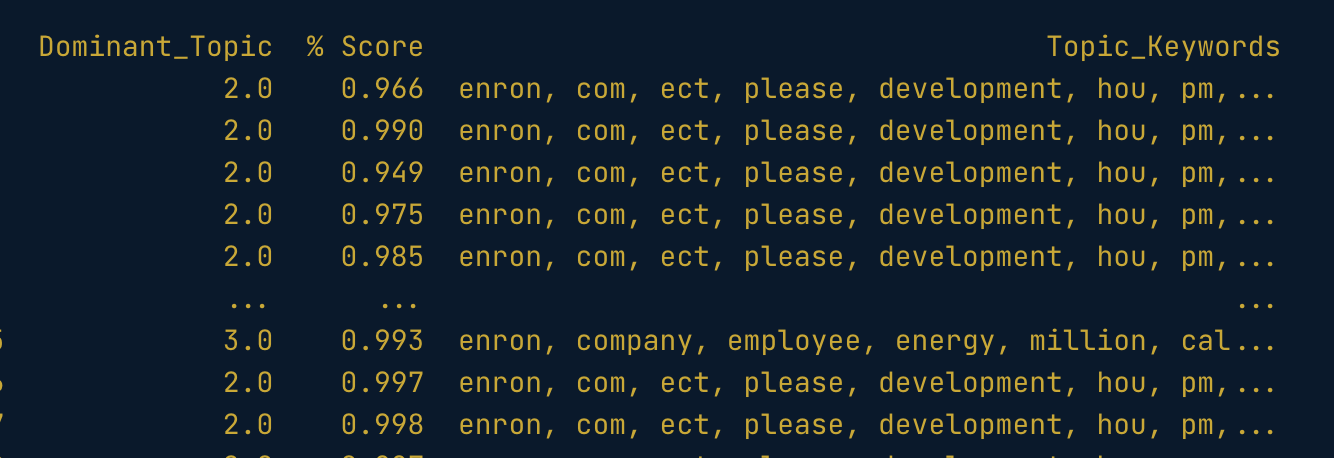

In [ ]:
# Add original text to topic details in a dataframe
contents = pd.DataFrame({'Original text': text_clean})
topic_details = pd.concat([get_topic_details(ldamodel, corpus), contents], axis=1)
# Create flag for text highest associated with topic 3
topic_details['flag'] = np.where((topic_details['Dominant_Topic'] == 3.0),1, 0)
print(topic_details.head())

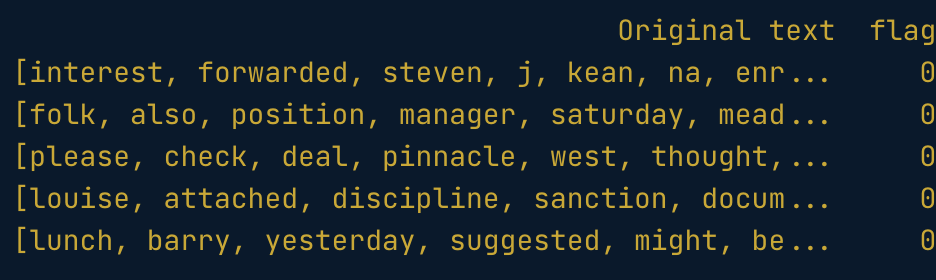